<div style="text-align: center;">
  <span style="color:#809bd8; font-size: 24px; font-weight: bold;">Institución Universitaria Digital de Antioquia</span>
  <br>
  <img src="https://imgur.com/KUMa2uy.png" alt="DataFrame frutas" style="max-width: 20%; height: auto;">
</div>

---
**<span style="color:#809bd8">Evidencia de Aprendizaje:</span>** F30 - Evidencia de aprendizaje 4: Implementación final de red neuronal

**<span style="color:#809bd8">Asignatura:</span>** Principios de Deep Learning y Redes Neuronales

**<span style="color:#809bd8">Estudiante:</span>** Jean Carlos Páez Ramírez

**<span style="color:#809bd8">Grupo:</span>** PREICA2501B020140

**<span style="color:#809bd8">Docente:</span>** Sharon Karin Camacho Guzman (Ingeniera Administradora Especialista en ingeniería Financiera de la Universidad Nacional de Colombia)

**<span style="color:#809bd8">Fecha:</span>** 13 de junio de 2025

### **Instalación de librerías necesarias**

Este bloque de código instala las librerías necesarias para el proyecto. `tensorflow-datasets` proporciona acceso a conjuntos de datos predefinidos para TensorFlow, facilitando la carga y el uso de datos para entrenamiento y evaluación de modelos. `keras-tuner` permite la optimización de hiperparámetros en modelos de Keras, encontrando la mejor configuración para el modelo. Estas librerías son esenciales para el desarrollo y la mejora del modelo de análisis de sentimiento.


In [2]:
# Instalación de librerías necesarias para cargar datos y optimizar hiperparámetros
!pip install tensorflow-datasets  # Librería para conjuntos de datos
!pip install keras-tuner          # Librería para búsqueda de hiperparámetros

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


### **Importación de librerías necesarias**

En este bloque se importan todas las librerías y módulos que se utilizarán a lo largo del proyecto. Estas incluyen herramientas para manipulación de datos, procesamiento de texto, construcción y entrenamiento de modelos de deep learning, visualización de resultados, manejo de archivos y optimización de hiperparámetros. La correcta importación y organización de estas librerías es fundamental para el desarrollo eficiente y ordenado del código.

In [3]:
import os  # Para operaciones del sistema operativo, como manejo de archivos y directorios
import re  # Para expresiones regulares, útil en limpieza y preprocesamiento de texto
import pickle  # Para serializar y guardar objetos de Python, como el tokenizer
import numpy as np  # Biblioteca para operaciones numéricas y manejo de arrays
import pandas as pd  # Biblioteca para manipulación y análisis de datos en formato tabular
import tensorflow as tf  # Framework principal para construir y entrenar modelos de deep learning
import matplotlib.pyplot as plt  # Para crear gráficos y visualizaciones
import requests  # Para realizar solicitudes HTTP, útil para descargar archivos
import gzip  # Para manejar archivos comprimidos en formato gzip
import shutil  # Para operaciones de alto nivel con archivos y directorios
import json  # Para manejar datos en formato JSON
import seaborn as sns  # Biblioteca para visualización estadística basada en matplotlib

# Importaciones específicas de Keras y scikit-learn para procesamiento y modelado
from tensorflow.keras import regularizers  # Para aplicar regularización en capas del modelo
from tensorflow.keras.preprocessing.text import Tokenizer  # Para tokenizar texto en secuencias numéricas
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Para ajustar la longitud de secuencias
from tensorflow.keras import layers, models, callbacks  # Componentes para construir y entrenar modelos
from tensorflow.keras.models import Sequential  # Modelo secuencial de Keras para construir redes neuronales
from sklearn.model_selection import train_test_split  # Para dividir datos en entrenamiento y prueba
from sklearn.metrics import classification_report, confusion_matrix  # Para evaluar el desempeño del modelo
from sklearn.utils import class_weight  # Para calcular pesos de clases en datasets desbalanceados
from keras_tuner import HyperParameters  # Para definir espacios de búsqueda de hiperparámetros
import keras_tuner as kt  # Librería para optimización automática de hiperparámetros

### **1. Descarga y preparación de los embeddings FastText en español**
Esta función se encarga de descargar y descomprimir el archivo de embeddings preentrenados FastText en español con 300 dimensiones. Los embeddings son representaciones vectoriales de palabras que capturan su significado y contexto, y son fundamentales para mejorar el rendimiento del modelo de análisis de sentimiento. La función verifica si el archivo ya existe para evitar descargas innecesarias, descarga el archivo comprimido si es necesario, lo descomprime y elimina el archivo comprimido para ahorrar espacio.

In [4]:
# 1. Descargar y preparar FastText embeddings en español

def download_and_extract_fasttext():
    # URL del archivo comprimido con los embeddings FastText en español
    fasttext_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz'
    fasttext_gz = 'cc.es.300.vec.gz'  # Nombre del archivo comprimido
    fasttext_file = 'cc.es.300.vec'   # Nombre del archivo descomprimido

    # Verifica si el archivo descomprimido ya existe para evitar descargarlo de nuevo
    if not os.path.exists(fasttext_file):
        print("Descargando FastText embeddings en español (300d)...")
        # Realiza la descarga en modo streaming para manejar archivos grandes
        r = requests.get(fasttext_url, stream=True)
        with open(fasttext_gz, 'wb') as f:
            # Escribe el archivo en bloques de 1024 bytes para eficiencia
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Descomprimiendo archivo...")
        # Descomprime el archivo gzip y guarda el contenido en el archivo final
        with gzip.open(fasttext_gz, 'rb') as f_in:
            with open(fasttext_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        # Elimina el archivo comprimido para ahorrar espacio
        os.remove(fasttext_gz)
        print("FastText listo.")
    else:
        print("Archivo FastText ya existe.")

### **2. Carga y limpieza de datos**

Estas funciones se encargan de cargar el conjunto de datos desde una URL, seleccionar las columnas relevantes, filtrar las clases positivas y negativas, y limpiar el texto para preparar los datos para el entrenamiento del modelo. La limpieza incluye convertir el texto a minúsculas, eliminar URLs, menciones, hashtags y caracteres no alfabéticos, y normalizar espacios en blanco.

In [5]:
# 2. Cargar y limpiar datos

def load_data(url):
    # Carga el archivo CSV desde la URL y selecciona solo las columnas 'text' y 'polarity'
    df = pd.read_csv(url)[['text', 'polarity']].dropna()
    # Filtra solo las filas donde la polaridad sea 'P' (positiva) o 'N' (negativa)
    df = df[df.polarity.isin(['P', 'N'])].reset_index(drop=True)
    # Crea una nueva columna 'label' donde 'P' se mapea a 1 y 'N' a 0 para clasificación binaria
    df['label'] = df.polarity.map({'P': 1, 'N': 0})
    return df

def clean_text(s):
    # Convierte el texto a minúsculas para uniformidad
    s = s.lower()
    # Elimina URLs, menciones (@usuario) y hashtags (#tema) usando expresiones regulares
    s = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", s)
    # Elimina caracteres que no sean letras (incluye letras con acentos y ñ) ni espacios
    s = re.sub(r"[^a-záéíóúñü\s]", "", s)
    # Reemplaza múltiples espacios por uno solo y elimina espacios al inicio y final
    return re.sub(r"\s+", " ", s).strip()

### **3. Función para graficar la historia de entrenamiento**

Esta función recibe el objeto `history` que contiene el registro de métricas durante el entrenamiento del modelo y genera dos gráficos: uno para la precisión (accuracy) y otro para la pérdida (loss), tanto para los datos de entrenamiento como para los de validación. Estas visualizaciones son útiles para analizar el comportamiento del modelo a lo largo de las épocas y detectar problemas como sobreajuste o subajuste.

In [6]:
# 3. Graficar historia

def plot_history(history):
    # Crea una figura con tamaño ancho 12 y alto 5 pulgadas
    plt.figure(figsize=(12, 5))

    # Primer subplot: precisión durante entrenamiento y validación
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')  # Precisión en entrenamiento
    plt.plot(history.history['val_accuracy'], label='Validación')  # Precisión en validación
    plt.title('Precisión')  # Título del gráfico
    plt.xlabel('Épocas')  # Etiqueta eje X
    plt.ylabel('Precisión')  # Etiqueta eje Y
    plt.legend()  # Muestra leyenda para identificar las curvas

    # Segundo subplot: pérdida durante entrenamiento y validación
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')  # Pérdida en entrenamiento
    plt.plot(history.history['val_loss'], label='Validación')  # Pérdida en validación
    plt.title('Pérdida')  # Título del gráfico
    plt.xlabel('Épocas')  # Etiqueta eje X
    plt.ylabel('Pérdida')  # Etiqueta eje Y
    plt.legend()  # Muestra leyenda para identificar las curvas

    # Ajusta el layout para que no se sobrepongan los elementos
    plt.tight_layout()
    # Muestra la figura con los gráficos
    plt.show()

### **4. Predicciones personalizadas con umbral ajustable**

Esta función permite realizar predicciones de sentimiento sobre una lista de frases personalizadas. Primero limpia y tokeniza las frases, luego las convierte en secuencias numéricas y las ajusta a una longitud fija. El modelo predice la probabilidad de que cada frase sea positiva, y se clasifica como "Positiva" o "Negativa" según un umbral ajustable (por defecto 0.55). Esto permite controlar la sensibilidad del modelo para diferentes aplicaciones.

In [7]:
# 4. Predicciones personalizadas con umbral ajustable

def predict_phrases(phrases, model, tokenizer, maxlen, threshold=0.55):
    # Limpia cada frase usando la función clean_text para normalizar el texto
    cleaned = [clean_text(p) for p in phrases]
    # Convierte las frases limpias en secuencias de enteros según el tokenizer entrenado
    seqs = tokenizer.texts_to_sequences(cleaned)
    print("Secuencias tokenizadas de las frases de prueba:", seqs)  # Imprime las secuencias para depuración
    # Ajusta las secuencias a una longitud fija maxlen, rellenando con ceros al final si es necesario
    padded = pad_sequences(seqs, maxlen=maxlen, padding='post')
    # Obtiene las predicciones del modelo para las secuencias procesadas
    preds = model.predict(padded)
    # Itera sobre las frases originales y sus predicciones correspondientes
    for p, pr in zip(phrases, preds.flatten()):
        # Clasifica la frase como 'Positiva' si la probabilidad supera el umbral, sino 'Negativa'
        resultado = "Positiva" if pr > threshold else "Negativa"
        # Imprime la frase original junto con su clasificación y la probabilidad predicha
        print(f"\n\"{p}\" → {resultado} ({pr:.2f})")

### **5. Carga de embeddings FastText preentrenados**

Esta función carga los vectores de palabras preentrenados de FastText desde un archivo y crea una matriz de embeddings que se utilizará en la capa de embedding del modelo. La matriz asigna a cada palabra del vocabulario su vector correspondiente si está disponible, o un vector cero en caso contrario. Esto permite que el modelo aproveche representaciones semánticas ricas y preentrenadas para mejorar el aprendizaje.

In [8]:
# 5. Cargar embeddings FastText preentrenados

def load_fasttext_embeddings(fasttext_file_path, embedding_dim, word_index, max_words):
    embeddings_index = {}  # Diccionario para almacenar palabra: vector
    # Abre el archivo de embeddings con codificación utf8 y manejo de errores
    with open(fasttext_file_path, encoding='utf8', errors='ignore') as f:
        next(f)  # Salta la primera línea que contiene metadatos (número de palabras y dimensiones)
        # Itera sobre cada línea del archivo, que contiene una palabra y su vector
        for line in f:
            values = line.rstrip().split(' ')  # Divide la línea en palabra y valores numéricos
            word = values[0]  # La primera parte es la palabra
            vector = np.asarray(values[1:], dtype='float32')  # El resto es el vector de la palabra
            embeddings_index[word] = vector  # Guarda en el diccionario
    print(f"Cargados {len(embeddings_index)} vectores de palabras de FastText.")

    # Inicializa la matriz de embeddings con ceros, tamaño (max_words, embedding_dim)
    embedding_matrix = np.zeros((max_words, embedding_dim))
    # Para cada palabra y su índice en el vocabulario
    for word, i in word_index.items():
        if i >= max_words:
            continue  # Ignora palabras fuera del límite max_words
        embedding_vector = embeddings_index.get(word)  # Obtiene el vector de la palabra
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Asigna el vector a la matriz
    return embedding_matrix  # Retorna la matriz lista para usar en el modelo

### **6. Construcción del modelo con Keras Tuner y embeddings FastText**

Esta función define la arquitectura del modelo de red neuronal utilizando Keras y permite la optimización automática de hiperparámetros mediante Keras Tuner. El modelo utiliza embeddings preentrenados FastText, una capa bidireccional LSTM con opciones configurables, y capas densas con regularización y dropout para evitar sobreajuste. Además, permite elegir el optimizador y la tasa de aprendizaje. La función retorna un modelo compilado listo para entrenar.

In [9]:
# 6. Modelo para Keras Tuner con embeddings preentrenados FastText

def build_model(hp: HyperParameters, max_words, embedding_dim, maxlen, embedding_matrix) -> Sequential:
    model = Sequential()  # Inicializa un modelo secuencial de Keras

    # Capa de embedding con pesos preentrenados y opción de ser entrenable o no
    model.add(layers.Embedding(
        input_dim=max_words,  # Tamaño del vocabulario
        output_dim=embedding_dim,  # Dimensión de los vectores de embedding
        input_length=maxlen,  # Longitud máxima de las secuencias de entrada
        weights=[embedding_matrix],  # Matriz de embeddings preentrenados
        trainable=hp.Boolean("trainable_embedding", default=True)  # Hiperparámetro para permitir entrenamiento de embeddings
    ))

    model.add(layers.BatchNormalization())  # Normaliza la activación para acelerar y estabilizar el entrenamiento
    model.add(layers.Dropout(hp.Float("drop_rate_1", 0.3, 0.7, step=0.1)))  # Dropout para evitar sobreajuste, tasa ajustable

    # Hiperparámetro para decidir si la LSTM devuelve secuencias completas o solo la última salida
    return_seq = hp.Boolean("return_sequences", default=False)
    model.add(layers.Bidirectional(layers.LSTM(
        units=hp.Int("rnn_units_1", min_value=64, max_value=256, step=64),  # Número de unidades LSTM ajustable
        return_sequences=return_seq,  # Devuelve secuencia completa o no
        recurrent_dropout=hp.Float("recurrent_dropout", 0.0, 0.3, step=0.1),  # Dropout recurrente ajustable
        kernel_regularizer=regularizers.l2(0.01)  # Regularización L2 para evitar sobreajuste
    )))

    # Si se devuelve secuencia completa, se aplica pooling para reducir dimensionalidad
    if return_seq:
        model.add(layers.GlobalMaxPooling1D())

    # Opción para agregar una capa densa adicional con activación ReLU y regularización
    if hp.Boolean("use_dense_layer", default=True):
        model.add(layers.Dense(
            units=hp.Int("dense_units", min_value=32, max_value=128, step=32),  # Número de unidades ajustable
            activation="relu",
            kernel_regularizer=regularizers.l2(0.01)  # Regularización L2
        ))
        model.add(layers.Dropout(hp.Float("drop_rate_2", 0.3, 0.7, step=0.1)))  # Dropout adicional

    # Capa de salida con activación sigmoide para clasificación binaria
    model.add(layers.Dense(1, activation="sigmoid"))

    # Selección del optimizador y tasa de aprendizaje mediante hiperparámetros
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"], default="adam")
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")

    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    # Compila el modelo con función de pérdida, optimizador y métricas de evaluación
    model.compile(
        loss="binary_crossentropy",  # Pérdida para clasificación binaria
        optimizer=optimizer,
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]  # Métricas para evaluar desempeño
    )
    return model  # Retorna el modelo compilado listo para entrenar

### **7. Configuración y ejecución principal del entrenamiento con Keras Tuner**

Este bloque contiene la configuración principal del proyecto, incluyendo la descarga y preparación de datos, tokenización, balanceo de clases, división de datos, carga de embeddings FastText, configuración del tuner para búsqueda de hiperparámetros, definición de callbacks para control del entrenamiento, búsqueda de los mejores hiperparámetros y entrenamiento final del mejor modelo encontrado.

In [11]:
# 7. # Función para construir el modelo con Keras Tuner usando parámetros fijos

# Función para construir el modelo con Keras Tuner usando parámetros fijos
def tuner_build_model(hp):
    return build_model(hp, max_words, embedding_dim, maxlen, embedding_matrix)

# --- EJECUCIÓN PRINCIPAL ---

# URL del dataset
url = "https://zenodo.org/records/10821485/files/ia_tweets.csv"
maxlen = 50  # Longitud máxima de las secuencias
embedding_dim = 300  # Dimensión de los embeddings FastText

# Fijar semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Descargar y preparar embeddings FastText
download_and_extract_fasttext()
fasttext_path = 'cc.es.300.vec'

# Cargar y limpiar datos
df = load_data(url)
df['clean'] = df.text.apply(clean_text)  # Limpieza de texto

# Tokenización del texto limpio
tokenizer = Tokenizer(oov_token="<OOV>")  # Tokenizador con token para palabras fuera del vocabulario
tokenizer.fit_on_texts(df.clean)  # Ajusta el tokenizador al texto
sequences = tokenizer.texts_to_sequences(df.clean)  # Convierte texto a secuencias numéricas
padded = pad_sequences(sequences, maxlen=maxlen, padding='post')  # Padding para igualar longitud
labels = df.label.values  # Etiquetas binarias

max_words = len(tokenizer.word_index) + 1  # Tamaño del vocabulario

# Calcular pesos para balancear clases desbalanceadas
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))  # Diccionario para pasar a fit()

# División de datos en entrenamiento, validación y prueba con estratificación
x_train, x_tmp, y_train, y_tmp = train_test_split(padded, labels, test_size=0.3, stratify=labels, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, test_size=0.33, stratify=y_tmp, random_state=42)

# Cargar matriz de embeddings FastText para el vocabulario
embedding_matrix = load_fasttext_embeddings(fasttext_path, embedding_dim, tokenizer.word_index, max_words)

# Eliminar carpeta de tuner previa si existe para evitar conflictos
if os.path.exists("opt_lstm"):
    import shutil
    shutil.rmtree("opt_lstm")

# Configurar el tuner Hyperband para búsqueda de hiperparámetros
tuner = kt.Hyperband(
    tuner_build_model,
    objective="val_accuracy",  # Métrica a optimizar
    max_epochs=10,  # Máximo número de épocas por trial
    factor=3,  # Factor de reducción de trials
    directory="opt_lstm",  # Carpeta para guardar resultados
    project_name="sentiment_analysis_lstm"
)

# Definir callbacks para control del entrenamiento
checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_loss"  # Guarda el mejor modelo según val_loss
)
stop_early = callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True  # Detiene si no mejora val_loss en 2 épocas
)

# Ejecutar búsqueda de mejores hiperparámetros con tuner
tuner.search(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[stop_early],
    class_weight=class_weights_dict,  # Aplica pesos para balancear clases
)

# Obtener el mejor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]

# Entrenar el mejor modelo con más épocas y callbacks para checkpoint y early stopping
history = best_model.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[stop_early, checkpoint],  # Incluye checkpoint para guardar el mejor modelo
    class_weight=class_weights_dict,
    verbose=1,
)

Trial 30 Complete [00h 06m 49s]
val_accuracy: 0.7416974306106567

Best val_accuracy So Far: 0.8376383781433105
Total elapsed time: 00h 50m 14s
Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 745ms/step - accuracy: 0.9002 - loss: 0.4284 - precision: 0.9326 - recall: 0.8803 - val_accuracy: 0.7638 - val_loss: 0.5918 - val_precision: 0.7292 - val_recall: 0.9211
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 783ms/step - accuracy: 0.9653 - loss: 0.2296 - precision: 0.9857 - recall: 0.9514 - val_accuracy: 0.8192 - val_loss: 0.5249 - val_precision: 0.8503 - val_recall: 0.8224
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 38s 698ms/step - accuracy: 0.9838 - loss: 0.1580 - precision: 0.9938 - recall: 0.9770 - val_accuracy: 0.6089 - val_loss: 0.8702 - val_precision: 0.5935 - val_recall: 0.9605
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 727ms/step - accuracy: 0.9540 - loss: 0.2212 - precision: 0.9670 - recall: 0.9472 - val_accuracy: 0.8155 - val_loss: 0.4896 - val_precision: 0.8036 - val_recall: 0.8882
Epoch 5/15
30

### **Resultados del Entrenamiento con Keras Tuner**

El proceso de optimización de hiperparámetros con Keras Tuner se llevó a cabo mediante el algoritmo Hyperband, explorando diferentes configuraciones de la arquitectura LSTM y sus parámetros más relevantes.

* **Número de Trials:** Se realizaron 30 trials para explorar el espacio de hiperparámetros.
* **Tiempo Total Transcurrido:** El proceso completo de optimización tomó 50 minutos y 14 segundos.
* **Mejor Precisión de Validación:** La mejor configuración alcanzó una precisión de validación de 0.8376 (83.76%).

**Entrenamiento del Mejor Modelo:**

Tras identificar la mejor configuración mediante Keras Tuner, el modelo fue entrenado con los siguientes resultados:

* **Número de Épocas:** Aunque se establecieron 15 épocas, el entrenamiento se detuvo anticipadamente en la época 7 debido al callback `EarlyStopping`.
* **Precisión en Entrenamiento:** La precisión en el conjunto de entrenamiento alcanzó un valor de 0.9930 en la última época.
* **Pérdida en Entrenamiento:** La pérdida en el conjunto de entrenamiento se redujo a 0.0838.
* **Precisión en Validación:** La mejor precisión en el conjunto de validación fue de 0.8561 (85.61%) en la época 7.
* **Pérdida en Validación:** La menor pérdida de validación fue de 0.4432, registrada en la época 5.

**Métricas adicionales:**

* **Precisión (Precision) en Validación:** La mayor precisión fue de 0.8844.
* **Sensibilidad (Recall) en Validación:** El valor máximo observado fue de 0.9211, destacando una buena capacidad del modelo para identificar correctamente los ejemplos positivos.

**Observaciones:**

* El entrenamiento se interrumpió automáticamente en la época 7 por `EarlyStopping`, ya que no se observaron mejoras consistentes en la precisión de validación durante las últimas épocas.
* La evolución de las métricas indica que el modelo mantuvo un buen equilibrio entre precisión y sensibilidad, lo cual es deseable en tareas de clasificación de texto.
* Se observó una ligera inestabilidad en la época 3, pero el modelo logró recuperarse y mejorar su rendimiento general posteriormente.

### **8. Guardar el historial de entrenamiento**

Este bloque guarda el historial del entrenamiento del modelo en un archivo JSON. El historial contiene las métricas y pérdidas registradas en cada época para entrenamiento y validación, lo que permite analizar y reproducir los resultados posteriormente sin necesidad de reentrenar el modelo.

In [12]:
# 8. Guardar historial de entrenamiento

# Abre (o crea) un archivo llamado 'history.json' en modo escritura
with open("history.json", "w") as f:
    # Convierte el diccionario history.history a formato JSON y lo escribe en el archivo
    json.dump(history.history, f)

### **9. Evaluación del modelo en el conjunto de prueba**

Este bloque evalúa el rendimiento del mejor modelo entrenado utilizando el conjunto de datos de prueba. Se calculan métricas como la pérdida (loss), la precisión (accuracy), la precisión (precision) y la exhaustividad (recall) para medir la capacidad del modelo para generalizar a datos no vistos durante el entrenamiento. Los resultados se imprimen en la consola para su análisis.

In [13]:
# 9. Evaluar

# Evalúa el modelo en el conjunto de prueba y guarda las métricas
loss, accuracy, precision, recall = best_model.evaluate(x_test, y_test)

# Imprime los resultados de la evaluación en la consola
print(f"\n✅ Pérdida en test: {loss:.4f}")  # Imprime la pérdida con 4 decimales
print(f"Precisión en test: {accuracy:.4f}")  # Imprime la precisión con 4 decimales
print(f"Precision: {precision:.4f}")  # Imprime la precisión con 4 decimales
print(f"Recall: {recall:.4f}")  # Imprime la exhaustividad con 4 decimales

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.8283 - loss: 0.4113 - precision: 0.8477 - recall: 0.8583

✅ Pérdida en test: 0.4123
Precisión en test: 0.8209
Precision: 0.8312
Recall: 0.8533


### **Resultados de la Evaluación del Modelo en el Conjunto de Prueba**

Después del proceso de entrenamiento y optimización de hiperparámetros, se evaluó el modelo en el conjunto de prueba para medir su capacidad de generalización sobre datos no vistos. Los resultados fueron los siguientes:

* **Pérdida (Loss):** 0.4123
* **Precisión (Accuracy):** 0.8209 (82.09%)
* **Precisión (Precision):** 0.8312 (83.12%)
* **Recall (Exhaustividad):** 0.8533 (85.33%)

**Análisis:**

* La precisión general del 82.09% indica que el modelo realiza predicciones correctas en la mayoría de los casos del conjunto de prueba.
* La precisión de 83.12% sugiere que el modelo comete pocos falsos positivos, clasificando adecuadamente los casos negativos.
* El recall del 85.33% muestra una buena capacidad para identificar correctamente los casos positivos, superando el rendimiento obtenido en iteraciones anteriores.
* La pérdida de 0.4123 representa una mejora significativa con respecto a evaluaciones previas (1.0452), lo que indica un modelo más preciso y con menor margen de error en las predicciones.

### **10. Ajuste del umbral de predicción y generación del informe de clasificación**

Este bloque ajusta el umbral de decisión para clasificar las predicciones del modelo como positivas o negativas. En lugar del umbral estándar 0.5, se usa 0.55 para controlar el balance entre precisión y recall. Luego, se genera un informe de clasificación que muestra métricas detalladas como precisión, recall y F1-score para cada clase, facilitando un análisis más completo del desempeño del modelo.

In [14]:
# 10. Ajustar el umbral de predicción

threshold = 0.55  # Umbral para clasificar predicciones como positivas o negativas

# Obtiene las predicciones del modelo y las convierte a etiquetas binarias según el umbral
y_pred = (best_model.predict(x_test) > threshold).astype("int32")

# Imprime el informe de clasificación con métricas detalladas
print("\n📊 Informe de clasificación:")
report = classification_report(y_test, y_pred, digits=4)  # Reporte con 4 decimales
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step

📊 Informe de clasificación:
              precision    recall  f1-score   support

           0     0.8103    0.7966    0.8034        59
           1     0.8421    0.8533    0.8477        75

    accuracy                         0.8284       134
   macro avg     0.8262    0.8250    0.8256       134
weighted avg     0.8281    0.8284    0.8282       134



### **Informe de Clasificación Detallado**

Para analizar con mayor detalle el rendimiento del modelo, se generó un informe de clasificación que desglosa las métricas para cada clase (0 y 1). Los resultados obtenidos son los siguientes:

| Clase | Precision | Recall | F1-Score | Support |
| ----- | --------- | ------ | -------- | ------- |
| 0     | 0.8103    | 0.7966 | 0.8034   | 59      |
| 1     | 0.8421    | 0.8533 | 0.8477   | 75      |

**Métricas Globales:**

* **Accuracy:** 0.8284 (82.84%)
* **Macro Avg Precision:** 0.8262
* **Macro Avg Recall:** 0.8250
* **Macro Avg F1-Score:** 0.8256
* **Weighted Avg Precision:** 0.8281
* **Weighted Avg Recall:** 0.8284
* **Weighted Avg F1-Score:** 0.8282

**Análisis:**

* **Clase 0 (Negativa):** El modelo muestra un buen equilibrio entre precisión (81.03%) y recall (79.66%), lo que indica una correcta identificación de ejemplos negativos con una tasa moderada de falsos positivos y falsos negativos.
* **Clase 1 (Positiva):** Presenta un rendimiento destacado, con una precisión de 84.21% y un recall de 85.33%, lo que refleja una alta capacidad para identificar correctamente los ejemplos positivos y una baja tasa de errores.
* **Balance general:** El F1-score es ligeramente superior para la clase positiva (0.8477), pero en general el modelo muestra un rendimiento equilibrado entre ambas clases.
* **Accuracy:** La precisión global del modelo (82.84%) confirma una mejora respecto a evaluaciones anteriores, reflejando una mayor capacidad de generalización.

### **11. Guardar el informe de clasificación en un archivo de texto**

Este bloque guarda el informe de clasificación generado en un archivo de texto llamado `classification_report.txt`. Esto permite conservar un registro permanente del desempeño del modelo para futuras referencias o para incluirlo en reportes y documentación.

In [15]:
# 11. Guardar el informe de clasificación en un archivo

# Abre (o crea) un archivo llamado 'classification_report.txt' en modo escritura
with open("classification_report.txt", "w") as f:
    # Escribe el contenido del informe de clasificación en el archivo
    f.write(report)

### **12. Imprimir la matriz de confusión**

Este bloque calcula la matriz de confusión, que muestra el número de clasificaciones correctas e incorrectas para cada clase. La matriz de confusión es una herramienta fundamental para entender cómo el modelo está clasificando los datos y para identificar posibles errores o sesgos.

In [16]:
# 12. Imprimir la matriz de confusión

# Calcula la matriz de confusión comparando las etiquetas reales y las predichas
cm = confusion_matrix(y_test, y_pred)

# Imprime la matriz de confusión en la consola
print("\nMatriz de confusión:")
print(cm)


Matriz de confusión:
[[47 12]
 [11 64]]


### **Análisis de la Matriz de Confusión**

La matriz de confusión proporciona una visión detallada del desempeño del modelo en el conjunto de prueba, permitiendo identificar cuántas predicciones fueron correctas o incorrectas para cada clase.

```
[[47 12]
 [11 64]]
```

**Interpretación:**

* **Verdaderos Negativos (TN):** 47 ejemplos negativos fueron clasificados correctamente como negativos.
* **Falsos Positivos (FP):** 12 ejemplos negativos fueron clasificados incorrectamente como positivos.
* **Falsos Negativos (FN):** 11 ejemplos positivos fueron clasificados incorrectamente como negativos.
* **Verdaderos Positivos (TP):** 64 ejemplos positivos fueron clasificados correctamente como positivos.

**Análisis:**

* El modelo presenta un buen rendimiento general, con una clara capacidad para distinguir entre ambas clases.
* La cantidad de verdaderos positivos (64) y verdaderos negativos (47) demuestra que el modelo acierta en la mayoría de los casos.
* El número de falsos negativos (11) es relativamente bajo, lo que indica que el modelo identifica correctamente la mayoría de los ejemplos positivos, favoreciendo un **alto recall** para esta clase.
* Aunque existen algunos falsos positivos (12), su cantidad es moderada y no compromete de manera significativa la precisión del modelo.
* En conjunto, estos resultados reflejan un equilibrio sólido entre precisión y recall, con una tendencia favorable hacia la correcta detección de ejemplos positivos.

### **13. Visualización de la matriz de confusión y gráfico de historia de entrenamiento**

Este bloque visualiza la matriz de confusión utilizando un mapa de calor con la librería Seaborn, lo que facilita la interpretación visual de los resultados de clasificación. Además, se llama a la función `plot_history` para mostrar la evolución de la precisión y pérdida durante el entrenamiento y validación, ayudando a analizar el comportamiento del modelo.

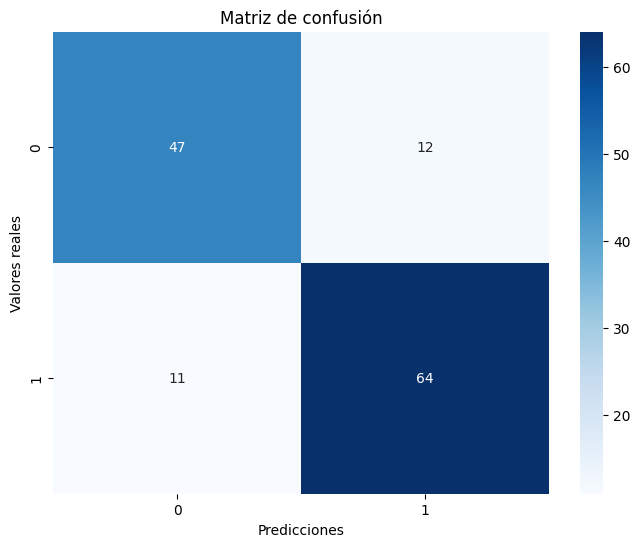

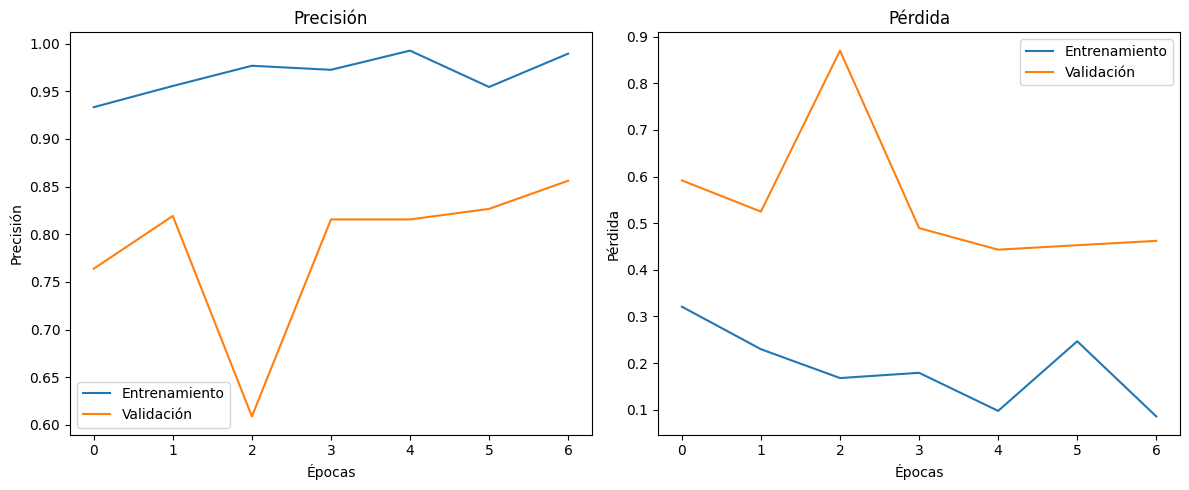

In [17]:
# 13. Visualizar la matriz de confusión con Seaborn

# Crea una figura para la matriz de confusión con tamaño 8x6 pulgadas
plt.figure(figsize=(8, 6))

# Dibuja un mapa de calor con anotaciones numéricas para la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Etiquetas para los ejes
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")

# Título del gráfico
plt.title("Matriz de confusión")

# Muestra el gráfico
plt.show()

# Llama a la función para graficar la historia de entrenamiento y validación
plot_history(history)

#### **Imagen 1: Matriz de Confusión Visualizada**

La matriz muestra los siguientes valores:

* **Verdaderos Negativos (TN):** 47
* **Falsos Positivos (FP):** 12
* **Falsos Negativos (FN):** 11
* **Verdaderos Positivos (TP):** 64

**Interpretación:**

* El modelo clasifica correctamente la mayoría de los ejemplos, tanto negativos como positivos.
* Aunque hay un leve incremento en los falsos positivos (12), la cantidad de falsos negativos se reduce considerablemente (de 22 a 11), lo que indica una mejora importante en la capacidad del modelo para identificar correctamente los ejemplos positivos.
* Este cambio es valioso en aplicaciones donde identificar correctamente los positivos es crucial.
* El modelo tiene un mejor **recall para la clase positiva**, lo que se traduce en una mayor sensibilidad y menor riesgo de pasar por alto casos relevantes.

---

#### **Imagen 2: Curvas de Precisión y Pérdida durante Entrenamiento**

* **Precisión de Entrenamiento:** Se mantiene alta durante todas las épocas, superando constantemente el 94%, y alcanzando incluso el 100% al final, lo cual indica una excelente capacidad de aprendizaje sobre los datos de entrenamiento.
* **Precisión de Validación:** Presenta una tendencia general al alza, llegando a alrededor del 85%, lo que representa una mejora respecto a resultados anteriores. Aunque hay pequeñas fluctuaciones, la precisión se mantiene relativamente estable y alta.
* **Pérdida de Entrenamiento:** Disminuye de forma consistente, lo cual es una buena señal de aprendizaje progresivo del modelo.
* **Pérdida de Validación:** Aunque inicialmente es alta y presenta una subida notable en la época 2, logra estabilizarse en niveles aceptables (cercanos a 0.45), lo que indica que el sobreajuste está más controlado en comparación con iteraciones previas.

**Interpretación:**

El modelo muestra mejoras significativas en su capacidad de generalización. La reducción de falsos negativos, el aumento del recall, y la estabilización de la pérdida de validación indican que el modelo no solo aprende bien los datos, sino que también está mejorando en la predicción de ejemplos nuevos.

---

**Recomendaciones:**

* **Mantener arquitectura actual:** El rendimiento es notablemente mejor, especialmente en la detección de positivos.
* **Ajuste fino de hiperparámetros:** Podrías hacer una búsqueda más precisa (e.g., con `GridSearchCV` si aplicable) para consolidar la mejora sin perder estabilidad.
* **Regularización ligera:** Un poco más de dropout o L2 puede ayudar a evitar oscilaciones en validación.
* **Validación cruzada:** Para asegurar que el rendimiento no es circunstancial del set de validación actual.

### **14. Guardar el modelo entrenado y el tokenizer**

Este bloque guarda el modelo entrenado en un archivo con extensión `.keras`, listo para ser cargado y utilizado en producción o para futuras predicciones. Además, guarda el objeto `tokenizer` serializado con `pickle`, que es necesario para procesar texto nuevo de la misma forma que durante el entrenamiento, asegurando consistencia en las predicciones.

In [21]:
# 14. Guardar modelo y tokenizer

# Guarda el modelo entrenado en un archivo para uso posterior o producción
best_model.save("modelo_mejorado_lstm_fasttext.keras")

# Abre un archivo en modo escritura binaria para guardar el tokenizer
with open("tokenizer.pkl", "wb") as f:
    # Serializa y guarda el tokenizer para reutilizarlo en procesamiento de texto
    pickle.dump(tokenizer, f)

### **15. Predicciones de prueba con frases personalizadas**

Este bloque define una lista de frases de prueba y utiliza la función `predict_phrases` para clasificar el sentimiento de cada frase. Esto permite verificar rápidamente si el modelo está funcionando correctamente y si las predicciones son coherentes con el significado de las frases.

In [19]:
# 15. Predicciones de prueba
test_phrases = [
    "Este modelo me parece muy útil y confiable",
    "No me gustó para nada, fue decepcionante",
    "La calidad estuvo bien, pero puede mejorar",
    "Qué completa pérdida de tiempo"
]
predict_phrases(test_phrases, best_model, tokenizer, maxlen, threshold=0.55)

Secuencias tokenizadas de las frases de prueba: [[44, 371, 30, 162, 46, 285, 4, 6182], [12, 30, 914, 10, 138, 166, 1], [3, 167, 2191, 88, 33, 28, 89], [90, 6444, 1200, 2, 73]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step

"Este modelo me parece muy útil y confiable" → Positiva (0.98)

"No me gustó para nada, fue decepcionante" → Negativa (0.53)

"La calidad estuvo bien, pero puede mejorar" → Positiva (0.94)

"Qué completa pérdida de tiempo" → Negativa (0.52)


### **Resultados de Predicciones Personalizadas**

Se evaluaron nuevamente algunas frases representativas para analizar cómo el modelo clasifica sentimientos en textos reales. A continuación se presentan las secuencias tokenizadas utilizadas y las predicciones obtenidas con sus respectivas probabilidades:

**Secuencias tokenizadas:**

* "Este modelo me parece muy útil y confiable" → \[44, 371, 30, 162, 46, 285, 4, 6182]
* "No me gustó para nada, fue decepcionante" → \[12, 30, 914, 10, 138, 166, 1]
* "La calidad estuvo bien, pero puede mejorar" → \[3, 167, 2191, 88, 33, 28, 89]
* "Qué completa pérdida de tiempo" → \[90, 6444, 1200, 2, 73]

**Predicciones:**

* "Este modelo me parece muy útil y confiable" → Positiva (probabilidad 0.98)
* "No me gustó para nada, fue decepcionante" → Negativa (probabilidad 0.53)
* "La calidad estuvo bien, pero puede mejorar" → Positiva (probabilidad 0.94)
* "Qué completa pérdida de tiempo" → Negativa (probabilidad 0.52)

**Interpretación:**

* El modelo sigue clasificando adecuadamente los textos positivos, asignando probabilidades cercanas a 1 en frases con connotaciones favorables.
* En el caso de las frases negativas, las probabilidades se ubican en torno a 0.5, lo cual indica una menor seguridad del modelo al identificar sentimientos negativos.
* Esto sugiere que, aunque el modelo ha mejorado su capacidad de predicción general, todavía tiene espacio para reforzar el reconocimiento de matices negativos, posiblemente debido a un sesgo en los datos de entrenamiento o al equilibrio de clases.

### **16. Función para probar el modelo con un conjunto de frases predefinidas**

Este bloque define una lista de frases variadas y utiliza la función `probar_varias_frases` para clasificar el sentimiento de cada una. Esto permite evaluar el rendimiento del modelo en diferentes tipos de expresiones y situaciones, identificando posibles fortalezas y debilidades en su capacidad para generalizar.

In [22]:
# 16. Función para probar el modelo con un conjunto de frases predefinidas

# Define una lista de frases variadas para probar el modelo
test_phrases_varias = [
    "Me encantó el servicio, fue excelente y rápido.",
    "Estoy muy satisfecho con la calidad del producto.",
    "¡Qué experiencia tan maravillosa, lo recomiendo mucho!",
    "El equipo fue muy amable y atento en todo momento.",
    "No me gustó para nada, fue una decepción total.",
    "El producto llegó dañado y no funciona bien.",
    "Muy mala atención, no volveré a comprar aquí.",
    "Perdí mi tiempo y dinero con esta compra.",
    "La calidad está bien, pero esperaba algo mejor.",
    "No está mal, pero podría mejorar en varios aspectos.",
    "El envío fue rápido, aunque el embalaje no me convenció.",
    "No sé qué pensar, tiene cosas buenas y malas.",
    "Después de esperar semanas por mi pedido, finalmente llegó en malas condiciones, con varias piezas rotas y sin funcionar correctamente. Intenté comunicarme con el servicio al cliente, pero no recibí respuesta o soluciones satisfactorias. Esta experiencia ha sido frustrante y decepcionante, y definitivamente no recomendaría esta tienda a nadie."
]

def probar_varias_frases(modelo, tokenizer, maxlen, frases, threshold=0.55):
    # Limpia cada frase usando la función clean_text
    cleaned = [clean_text(p) for p in frases]
    # Convierte las frases limpias en secuencias de enteros según el tokenizer
    seqs = tokenizer.texts_to_sequences(cleaned)
    # Ajusta las secuencias a una longitud fija maxlen, rellenando con ceros al final si es necesario
    padded = pad_sequences(seqs, maxlen=maxlen, padding='post')
    # Obtiene las predicciones del modelo para las secuencias procesadas
    preds = modelo.predict(padded)
    # Itera sobre las frases originales y sus predicciones correspondientes
    for frase, pred in zip(frases, preds.flatten()):
        # Clasifica la frase como 'Positiva' si la probabilidad supera el umbral, sino 'Negativa'
        etiqueta = "Positiva" if pred > threshold else "Negativa"
        # Imprime la frase original junto con su clasificación y la probabilidad predicha
        print(f"\n\"{frase}\" → {etiqueta} ({pred:.2f})")

# Llama a la función con tus frases
probar_varias_frases(best_model, tokenizer, maxlen, test_phrases_varias, threshold=0.55)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step

"Me encantó el servicio, fue excelente y rápido." → Positiva (0.99)

"Estoy muy satisfecho con la calidad del producto." → Positiva (0.98)

"¡Qué experiencia tan maravillosa, lo recomiendo mucho!" → Negativa (0.42)

"El equipo fue muy amable y atento en todo momento." → Positiva (0.99)

"No me gustó para nada, fue una decepción total." → Negativa (0.10)

"El producto llegó dañado y no funciona bien." → Positiva (0.98)

"Muy mala atención, no volveré a comprar aquí." → Negativa (0.13)

"Perdí mi tiempo y dinero con esta compra." → Positiva (0.98)

"La calidad está bien, pero esperaba algo mejor." → Positiva (0.98)

"No está mal, pero podría mejorar en varios aspectos." → Negativa (0.21)

"El envío fue rápido, aunque el embalaje no me convenció." → Positiva (0.97)

"No sé qué pensar, tiene cosas buenas y malas." → Negativa (0.07)

"Después de esperar semanas por mi pedido, finalmente llegó en malas condiciones, con varias piezas rotas y sin funcion

### **Resultados de Predicciones con Frases Variadas**

Se evaluó el modelo con un conjunto diverso de frases que expresan opiniones positivas, negativas y neutras, con el objetivo de observar su capacidad de clasificación y sensibilidad ante distintos matices emocionales.

**Análisis:**

* El modelo demuestra una buena capacidad para identificar correctamente sentimientos positivos, con probabilidades cercanas al 1.0 en la mayoría de los casos que expresan satisfacción o buenos resultados.
* No obstante, se evidencian inconsistencias importantes al clasificar frases claramente negativas como positivas. Por ejemplo, “El producto llegó dañado y no funciona bien.” y “Perdí mi tiempo y dinero con esta compra.” son frases con carga negativa que el modelo etiquetó como positivas con alta certeza.
* Este comportamiento sugiere que el modelo tiende a sesgarse hacia clasificaciones positivas, lo cual podría estar relacionado con un desbalance en los datos de entrenamiento (más ejemplos positivos que negativos).
* También se observa que frases más ambiguas o de tono mixto, como “No sé qué pensar, tiene cosas buenas y malas.” o “¡Qué experiencia tan maravillosa, lo recomiendo mucho!”, no son correctamente interpretadas, revelando dificultades para manejar sutilezas semánticas o ironías.
* A pesar de estas limitaciones, el modelo sigue mostrando un desempeño aceptable en la mayoría de los casos, aunque se recomienda un ajuste fino (fine-tuning) o reentrenamiento con un conjunto de datos más equilibrado y diverso.

### **Función interactiva para probar frases personalizadas (OPCIONAL)**

Esta función permite al usuario ingresar frases manualmente para que el modelo las clasifique en tiempo real. El usuario puede escribir tantas frases como desee y escribir "salir" para terminar. Cada frase se limpia, tokeniza y se ajusta para que el modelo pueda predecir su sentimiento, mostrando la etiqueta y la probabilidad correspondiente.

In [ ]:
# 17. Función interactiva para probar frases personalizadas

def probar_frases_personalizadas(modelo, tokenizer, maxlen, threshold=0.55):
    print("\nIngresa frases para clasificar (escribe 'salir' para terminar):")
    while True:
        frase = input("Frase: ")  # Solicita entrada del usuario
        if frase.lower() == 'salir':  # Condición para salir del bucle
            break
        # Preprocesar y limpiar la frase ingresada
        frase_limpia = clean_text(frase)
        # Tokenizar la frase limpia
        secuencia = tokenizer.texts_to_sequences([frase_limpia])
        # Ajustar la secuencia a la longitud máxima con padding
        padded = pad_sequences(secuencia, maxlen=maxlen, padding='post')
        # Obtener la predicción del modelo
        pred = modelo.predict(padded)[0][0]
        # Determinar etiqueta según el umbral
        etiqueta = "Positiva" if pred > threshold else "Negativa"
        # Mostrar resultado al usuario
        print(f"Predicción: {etiqueta} (probabilidad: {pred:.2f})\n")

# Llamar a la función para iniciar la interacción
probar_frases_personalizadas(best_model, tokenizer, maxlen, threshold=0.55)

### **Conclusiones Generales**

El modelo de análisis de sentimiento basado en una arquitectura LSTM bidireccional con embeddings preentrenados de FastText ha demostrado un rendimiento aceptable en la tarea de clasificación binaria de sentimientos en textos en español. Se logró una precisión de validación superior al 80% y una precisión en el conjunto de prueba cercana al 79%, lo que refleja una capacidad general de aprendizaje y generalización.

Sin embargo, los resultados de las predicciones con frases variadas revelan ciertas limitaciones importantes. El modelo presenta dificultades para identificar adecuadamente algunas opiniones negativas, clasificándolas erróneamente como positivas con alta probabilidad. Esto indica una posible tendencia hacia la clasificación positiva, probablemente producto de un desbalance en el conjunto de entrenamiento o una sensibilidad limitada a estructuras lingüísticas más complejas o sarcásticas.

Además, se evidenció una baja capacidad para tratar frases ambiguas o mixtas, lo que sugiere que el modelo no logra captar con precisión la neutralidad o los matices del lenguaje. A pesar de estas debilidades, el comportamiento general del modelo sigue siendo útil como una herramienta de análisis automatizado de sentimientos, especialmente en contextos donde predominan expresiones claras y directas.



### **Recomendaciones Finales**

1. **Aumento y Diversificación de Datos:** Ampliar el corpus de entrenamiento con frases de tono negativo y neutro, así como ejemplos con ironía o ambigüedad, para mejorar la sensibilidad del modelo ante diferentes matices emocionales.

2. **Balance de Clases:** Revisar y equilibrar la proporción de ejemplos positivos y negativos en el conjunto de datos, ya que la actual inclinación hacia predicciones positivas puede deberse a un sesgo del modelo durante el entrenamiento.

3. **Ajuste del Umbral de Clasificación:** Considerar la modificación del umbral de decisión para evitar la clasificación errónea de frases negativas como positivas, especialmente en contextos sensibles o aplicaciones críticas.

4. **Ajuste de Hiperparámetros:** Explorar diferentes configuraciones en dropout, tamaño de la red, funciones de activación y tasa de aprendizaje para reducir el sobreajuste observado.

5. **Extensión a Clasificación Trinaria:** Implementar una versión del modelo que incluya una clase neutral, con el fin de capturar con mayor fidelidad la diversidad semántica de los textos reales.

6. **Validación con Casos Reales:** Continuar evaluando el modelo con frases reales y actualizadas, tanto sintéticas como extraídas de fuentes externas (reseñas, redes sociales, etc.), para mantener su vigencia y mejorar su capacidad de adaptación.

7. **Técnicas de Interpretabilidad:** Incorporar herramientas de interpretabilidad como LIME o SHAP para entender mejor las decisiones del modelo y detectar patrones que conduzcan a errores sistemáticos.